In [7]:
import os
# Use cpu for jax
os.environ["JAX_PLATFORMS"] = "cpu"
import struct as st
import numpy as np
import cv2
from typing import Any, Dict
import grain.python as pygrain
from array_record.python.array_record_module import ArrayRecordWriter
import json
import pyarrow # Required by ArrayRecordSampleWriter for GCS copy
import jax
import jax.numpy as jnp # Required by clean_dataset
import time # For timing the clean_dataset function
import traceback # For error handling in clean_dataset
import tqdm # For progress bar in clean_dataset
import matplotlib.pyplot as plt # For plotting images

def unpack_dict_of_byte_arrays(packed_data):
    """Unpacks a dictionary of byte arrays from a packed binary format."""
    unpacked_dict = {}
    offset = 0
    while offset < len(packed_data):
        # Unpack the key length
        key_length = st.unpack_from('I', packed_data, offset)[0]
        offset += st.calcsize('I')
        # Unpack the key bytes and convert to string
        key = packed_data[offset:offset+key_length].decode('utf-8')
        offset += key_length
        # Unpack the byte array length
        byte_array_length = st.unpack_from('I', packed_data, offset)[0]
        offset += st.calcsize('I')
        # Unpack the byte array
        byte_array = packed_data[offset:offset+byte_array_length]
        offset += byte_array_length
        unpacked_dict[key] = byte_array
    return unpacked_dict

def pack_dict_of_byte_arrays(data_dict):
    import struct
    """
    Pack a dictionary of byte arrays into a single byte array.
    
    Args:
        data_dict (dict): Dictionary where keys are strings and values are byte arrays.
        
    Returns:
        bytes: Packed byte array.
    """
    packed_data = bytearray()
    
    for key, byte_array in data_dict.items():
        # Ensure the key is a string
        if not isinstance(key, str):
            raise ValueError("Keys must be strings")
        
        # Convert the key to bytes
        key_bytes = key.encode('utf-8')
        
        # Pack the key length and key bytes
        packed_data.extend(struct.pack('I', len(key_bytes)))
        packed_data.extend(key_bytes)
        
        # Pack the byte array length and byte array
        packed_data.extend(struct.pack('I', len(byte_array)))
        packed_data.extend(byte_array)
    
    return bytes(packed_data)

def image_augmenter(image, image_scale, method=cv2.INTER_AREA):
    """Basic image augmentation: convert color and resize."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_scale, image_scale),
                       interpolation=method)
    return image

def get_source(path: str = "/home/mrwhite0racle/gcs_mount/datasets/laion12m+mscoco") -> Any:
    """
    Get the GCS data source. 
    """
    records_path = path
    records = [os.path.join(records_path, i) for i in os.listdir(
        records_path) if 'array_record' in i][0]
    return pygrain.ArrayRecordDataSource([records])

class GCSTransform(pygrain.MapTransform):
    """
    Transform for GCS data source.
    """
    def __init__(self, image_scale: int = 256, method=cv2.INTER_AREA):
        super().__init__()
        self.image_scale = image_scale
        self.method = method
        from transformers import AutoTokenizer, AutoProcessor
        self.processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def map(self, data: Dict[str, Any]) -> Dict[str, Any]:
        try:
            element = unpack_dict_of_byte_arrays(data)
            image = np.asarray(bytearray(element['jpg']), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
            image = image_augmenter(image, self.image_scale, self.method)
            text = element['txt'].decode('utf-8')
            tokens = self.processor(
                images=image,
                text=text,
                return_tensors="np",
                padding="max_length",
                truncation=True,
                max_length=77,
            )
            return {
                'image': tokens['pixel_values'][0],
                'text': text,
                "image_jpg": element['jpg'],
                "input_ids": tokens['input_ids'][0],
                "attention_mask": tokens['attention_mask'][0],
            }
        except Exception as e:
            print(f"Error in GCSTransform: {e}")
            traceback.print_exc()
            return None
        
class TokenizeTransform(pygrain.MapTransform):
    """
    Transform for tokenizing text data.
    """
    def __init__(self):
        super().__init__()
        from transformers import AutoTokenizer, AutoProcessor
        self.tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
    def map(self, data: Dict[str, Any]) -> Dict[str, Any]:
        image = data['image']
        text = [str(i) for i in data['text']]
        
        # Tokenize
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="jax",
            padding="max_length",
            truncation=True,
            max_length=77,
        )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'pixel_values': inputs['pixel_values'],
            'image_jpg': data['image_jpg'],
        }

In [8]:
import requests
from io import BytesIO
from PIL import Image
def load_sample_image():
    """Load a sample image if no image path is provided."""
    print("Downloading a sample image...")
    # Use a relatively small but detailed image
    url = 'https://www.caledoniaplay.com/wp-content/uploads/2016/01/EDU-PRODUCT-DESCRIPTION-gallery-image-OUTDOOR-SEATING-RUSTIC-LOG-BENCH-1-555x462.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return np.array(img) # Normalize to [0, 1]

img = load_sample_image()


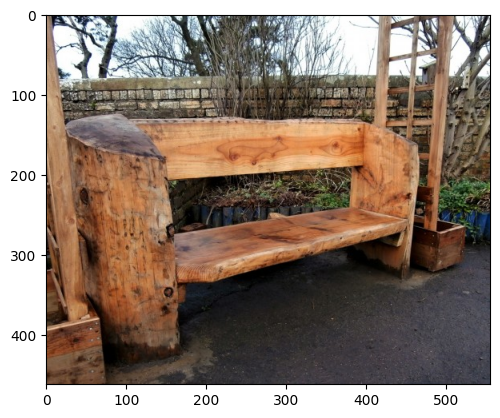

In [9]:
plt.imshow(img)

In [24]:

records_source = get_source()#"/home/mrwhite0racle/persist/datasets/laion12m+mscoco_filtered") # Use your actual path
transforms = [
    GCSTransform(),
    # TokenizeTransform(),
]

sampler = pygrain.IndexSampler(
    num_records=len(records_source),
    shuffle=False,
    seed=0,
    num_epochs=1,
    shard_options=pygrain.ShardByJaxProcess(),
)

loader = pygrain.DataLoader(
    data_source=records_source,
    sampler=sampler,
    operations=transforms,
    worker_count=1,
    read_options=pygrain.ReadOptions(
        num_threads=150,
        prefetch_buffer_size=100,
        ),
    worker_buffer_size=10,
)

dataset = iter(loader)
# batch = next(dataset)

In [30]:
k = []
for batch in tqdm.tqdm(dataset):
    k.append(batch['image'])

0it [00:00, ?it/s]


In [22]:
image = np.asarray(bytearray(batch['image_jpg']), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

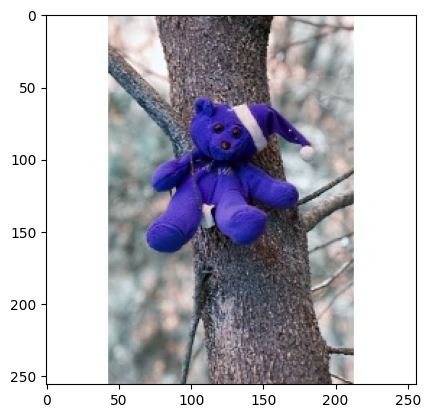

In [23]:
plt.imshow(image)

In [15]:
a = {
    # "key": "jpg",
    "jpg": batch['image_jpg'],
    # "txt": batch['text'],
}

packed_data = pack_dict_of_byte_arrays(a)

In [16]:
unpacked = unpack_dict_of_byte_arrays(packed_data)
unpacked['jpg']

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\

In [11]:
import matplotlib.pyplot as plt

(array([ 4.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 67.]),
 array([  320.  ,   810.87,  1301.74,  1792.61,  2283.48,  2774.35,
         3265.22,  3756.09,  4246.96,  4737.83,  5228.7 ,  5719.57,
         6210.44,  6701.31,  7192.18,  7683.05,  8173.92,  8664.79,
         9155.66,  9646.53, 10137.4 , 10628.27, 11119.14, 11610.01,
        12100.88, 12591.75, 13082.62, 13573.49, 14064.36, 14555.23,
        15046.1 , 15536.97, 16027.84, 16518.71, 17009.58, 17500.45,
        17991.32, 18482.19

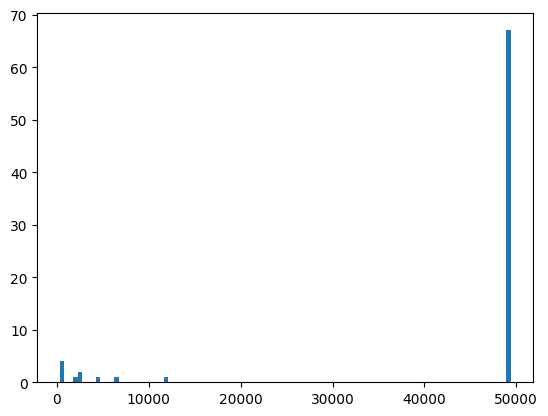

In [12]:
plt.hist(batch['input_ids'].flatten(), bins=100)

In [3]:
def get_clip_metric(
    modelname: str = "openai/clip-vit-large-patch14",
):
    from transformers import AutoProcessor, FlaxCLIPModel
    model = FlaxCLIPModel.from_pretrained(modelname, dtype=jnp.float16)
    processor = AutoProcessor.from_pretrained(modelname, use_fast=False, dtype=jnp.float16)
    
    @jax.jit
    def calc(pixel_values, input_ids, attention_mask):
        # Get the logits
        generated_out = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
            
        gen_img_emb = generated_out.image_embeds
        txt_emb = generated_out.text_embeds

        # 1. Normalize embeddings (essential for cosine similarity/distance)
        gen_img_emb = gen_img_emb / (jnp.linalg.norm(gen_img_emb, axis=-1, keepdims=True) + 1e-6)
        txt_emb = txt_emb / (jnp.linalg.norm(txt_emb, axis=-1, keepdims=True) + 1e-6)

        # 2. Calculate cosine similarity
        # Using einsum for batch dot product: batch (b), embedding_dim (d) -> bd,bd->b
        # Calculate cosine similarity

            # Compute cosine similarity
        similarity = jnp.sum(gen_img_emb * txt_emb, axis=-1)
        return similarity
        
    def clip_similarity(
        batch
    ):
        pixel_values = batch['image']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        return calc(pixel_values, input_ids, attention_mask)
    
    return clip_similarity, processor

In [ ]:
# Clean the dataset using clip score
def clean_dataset(dataloader):
    compute_similarity, processor = get_clip_metric()
    
    # Define the core computation function and JIT compile it for performance
    batch_count = 0
    yielded_count = 0
    skipped_batches = 0
    pbar = tqdm.tqdm(desc="Processing batches", unit="batch")
    for batch in dataloader:
        if batch is None:
            print("Received None batch, skipping...")
            skipped_batches += 1
            continue
        batch_count += 1
        try:
            start = time.time()
            # Compute similarity scores using the JIT-compiled function
            similarity = compute_similarity(batch)
            
            total_time = time.time() - start
            
            similarity = np.array(similarity) # Convert JAX array back to NumPy for easier handling

            # Filter out images with similarity less than 0.25
            # Ensure mask is boolean
            mask = similarity >= 0.22
            # print(f"Batch {batch_count} processed in {total_time:.2f} seconds. Filtered {np.sum(~mask)} items out of {len(mask)}.")

            # Apply the mask. Use list comprehensions or boolean indexing if inputs are numpy arrays
            # Ensure inputs are lists for consistent zipping and filtering
            texts = batch['text']
            jpgs = batch['image_jpg']
            filtered_texts = [txt for txt, m in zip(texts, mask) if m]
            filtered_jpgs = [jpg for jpg, m in zip(jpgs, mask) if m]

            pbar.update(1)

            if batch_count % 100 == 0:
                print(f"Processed {batch_count} batches. Yielded {yielded_count} samples so far. Skipped {skipped_batches} batches due to errors/empty.")

            pbar.set_postfix({"batch": batch_count, "filtered": len(filtered_texts)})
            # Only yield if there are any items left after filtering
            if filtered_jpgs:
                yielded_count += len(filtered_jpgs)
                yield {
                    # Note: Yielding 'image' (processed numpy) might not be needed
                    # if only 'image_jpg' (original bytes) is saved.
                    # 'image': filtered_images,
                    'text': filtered_texts,
                    'image_jpg': filtered_jpgs,
                }
        except Exception as e:
            print(f"Error processing batch {batch_count} with CLIP: {e}. Skipping batch.")
            traceback.print_exc()
            skipped_batches += 1
            continue # Skip to the next batch on error
    print(f"Finished cleaning dataset. Processed {batch_count} total batches.")
    print(f"Yielded a total of {yielded_count} filtered samples.")
    print(f"Skipped {skipped_batches} batches due to errors, missing data, or being empty.")



from array_record.python.array_record_module import ArrayRecordWriter
import json
import pyarrow

class ArrayRecordSampleWriter:
    """ArrayRecordSampleWriter is a writer to ArrayRecord format"""

    def __init__(
        self,
        shard_id,
        output_folder,
        save_caption,
        oom_shard_count,
        schema,
        encode_format,
    ):
        self.oom_shard_count = oom_shard_count
        self.encode_format = encode_format
        self.save_caption = save_caption
        shard_name = "{shard_id:0{oom_shard_count}d}".format(  # pylint: disable=consider-using-f-string
            shard_id=shard_id, oom_shard_count=oom_shard_count
        )
        # self.buffered_parquet_writer = BufferedParquetWriter(output_folder + "/" + shard_name + ".parquet", schema, 100)
        self.output_file = f"{output_folder}/{shard_name}.array_record"
        if "gs:" in output_folder:
            self.tmp_file = f'/tmp/{shard_name}.array_record'
        else:
            self.tmp_file = self.output_file
        self.writer = ArrayRecordWriter(self.tmp_file, options=f"group_size:1")
        
    def write(self, img_str, key, caption, meta):
        """Write sample to ArrayRecord"""
        if img_str is not None:
            sample = {
                "key": self._bytes_feature(key.encode()),
                self.encode_format: self._bytes_feature(img_str),
            }
            if self.save_caption:
                sample["txt"] = caption.encode() if caption is not None else b""
            for k, v in meta.items():
                if isinstance(v, np.ndarray):
                    meta[k] = v.tolist()
            sample["meta"] = json.dumps(meta).encode()
            self.writer.write(pack_dict_of_byte_arrays(sample))
        # self.buffered_parquet_writer.write(meta)
            
    def _bytes_feature(self, value):
        if value is None:
            value = ""
        if isinstance(value, str):
            value = value.encode()
        return value

    def close(self):
        self.writer.close()
        # self.buffered_parquet_writer.close()
        if self.tmp_file != self.output_file:
            pyarrow.fs.copy_files(self.tmp_file, self.output_file, chunk_size=2**24)
        os.remove(self.tmp_file)

In [5]:
def process_dataset(dataloader, output_folder, num_samples_per_shard=10000, oom_shard_count=6):
    """
    Process the dataset: filter using CLIP scores and save valid pairs to ArrayRecord shards.

    Args:
        dataloader: Iterable yielding batches of data (expected format from GCSTransform/Batch).
        output_folder: Path to the directory where ArrayRecord shards will be saved (local or gs://).
        num_samples_per_shard: Approximate number of samples per output shard file.
        oom_shard_count: Number of digits for zero-padding shard filenames (e.g., 6 -> 000001.array_record).
    """
    # Ensure the output folder exists locally if not using GCS.
    # For GCS, the ArrayRecordSampleWriter handles temporary local files.
    if not output_folder.startswith("gs://"):
        os.makedirs(output_folder, exist_ok=True)
        print(f"Ensured local output directory exists: {output_folder}")
    else:
        print(f"Outputting to GCS bucket path: {output_folder}")
        # GCS directory creation is implicitly handled by pyarrow during upload if needed/permissions allow.

    shard_id = 0
    samples_in_current_shard = 0
    total_samples_written = 0
    writer = None
    # Define parameters needed by ArrayRecordSampleWriter based on data format
    encode_format = 'jpg'  # Matches the key used in GCSTransform for image bytes
    save_caption = True    # We want to save the 'txt' field

    print(f"Starting dataset processing. Outputting to: {output_folder}")
    print(f"Target samples per shard: {num_samples_per_shard}")

    try:
        # Get the iterator for the filtered data
        filtered_data_iterator = clean_dataset(dataloader)

        # Iterate through the filtered batches yielded by clean_dataset
        for batch_num, filtered_batch in enumerate(filtered_data_iterator):
            # filtered_batch contains lists: 'text', 'image_jpg'
            filtered_jpgs = filtered_batch['image_jpg']
            filtered_texts = filtered_batch['text']

            # Iterate through individual samples within the filtered batch
            for img_jpg_bytes, text_caption in tqdm.tqdm(zip(filtered_jpgs, filtered_texts)):

                # Check if a new shard writer is needed (start of processing or shard full)
                if writer is None or samples_in_current_shard >= num_samples_per_shard:
                    if writer is not None:
                        # Close the previous writer (handles cleanup/upload)
                        print(f"Target samples reached for shard {shard_id}. Closing writer.")
                        writer.close()
                        shard_id += 1 # Increment shard ID for the next file
                        samples_in_current_shard = 0 # Reset counter for the new shard

                    # Create and open a new writer for the current shard
                    print(f"Creating writer for shard {shard_id}...")
                    writer = ArrayRecordSampleWriter(
                        shard_id=shard_id,
                        output_folder=output_folder,
                        save_caption=save_caption,
                        oom_shard_count=oom_shard_count,
                        schema=None,  # Schema is not directly used by ArrayRecord part here
                        encode_format=encode_format,
                    )
                    if samples_in_current_shard != 0:
                        print("Error: samples_in_current_shard was not 0 when creating new writer.")
                        samples_in_current_shard = 0


                # Prepare sample data for writing
                # Use a unique key for each sample, e.g., based on total count
                # This key is currently stored in the 'meta' field by the writer.
                sample_key = f"sample_{total_samples_written}"
                meta = {} # Add any other relevant metadata here if available

                # Write the current sample using the active writer
                if writer:
                     writer.write(img_str=img_jpg_bytes, key=sample_key, caption=text_caption, meta=meta)
                     samples_in_current_shard += 1
                     total_samples_written += 1
                else:
                     print(f"Error: Writer for shard {shard_id} was not initialized. Skipping sample {sample_key}")


                # Optional: Log progress periodically within a shard
                if total_samples_written % 1000 == 0:
                     print(f"  ... processed {total_samples_written} total samples (current shard: {samples_in_current_shard}/{num_samples_per_shard})")

            # Optional: Log progress after each batch from the clean_dataset generator
            # print(f"Finished processing filtered batch {batch_num + 1}. Samples in batch: {len(filtered_jpgs)}")


        # After the loop finishes, ensure the last active writer is closed
        if writer is not None:
            print(f"Finished processing all data. Closing final writer for shard {shard_id}.")
            writer.close()
        else:
            print("No data was processed or written.")

        print(f"\nDataset processing complete.")
        print(f"Total samples written: {total_samples_written}")
        if total_samples_written > 0:
             print(f"Total shards created: {shard_id + 1}")
        else:
             print(f"Total shards created: 0")

    except Exception as e:
        print(f"An error occurred during the main processing loop: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback
        # Ensure the current writer is closed cleanly even if an error occurs mid-shard
        if writer is not None:
             print(f"Closing writer for shard {shard_id} due to error.")
             writer.close()
        # Depending on the desired behavior, you might want to re-raise the exception
        # raise e
    finally:
        # Final check to ensure no writer object is left hanging, although try/except should handle it
        if 'writer' in locals() and writer is not None and writer.writer is not None:
             print("Attempting final cleanup close of writer...")
             writer.close()



In [ ]:
process_dataset(
    dataloader=dataset,
    output_folder="/home/mrwhite0racle/gcs_mount/datasets/laion12m+mscoco_filtered",
)

Ensured local output directory exists: /home/mrwhite0racle/gcs_mount/datasets/laion12m+mscoco_filtered
Starting dataset processing. Outputting to: /home/mrwhite0racle/gcs_mount/datasets/laion12m+mscoco_filtered
Target samples per shard: 10000
